# Example 3: Invert a Receiver Function
In this example we are going to load a receiver function that has been created from seismograms recorded at station  Hyderabad, India, of earthquakes that occurred in the Philipines. The source station configuration is identical to the one in example 1. We are going to work with receiver function, as in example 2. This example explores the provisions of `pyraysum` for time optimized execution. We are going to directly invoke the Fortran routine `run_bare` from the `fraysum` module with `python` convenience functions from the `prs` module. The inversion will be carried out by the `dual_annealing` function from `scipy.optimize`. The filtering and spectral division that is required to create receiver functions from the synthetic seismograms is carried out using `numpy` array methods. finally, we will plot the results with `matplotlib`.

In [1]:
from pyraysum import prs
from fraysum import run_bare
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as mp

## Definition of the Forward Computation
We predict waveforms inside a function `predictRF()` that accepts `Model`, `Geometry`, and `RC` objects, which completely define the synthetic seismograms to be computed. Only the `fthickn` and `fvs` attributes of the `Model` will be varied when trying different parameter combinations. The post-processing is determined by the bandpass filter corner frequencies `freqs` and the boolean time window mask `ist` ("is time"). Post processing is performed on the `numpy.ndarray` variable `rfarray`. Two post-processing functions are provided. `filtered_rf_array` divides the SV- and SH-spectra by the P-spectra (i.e., computes a receiver function) and filters the data, whereas `filtered_array` returns the filtered SV and SH data.

In [2]:
def predictRF(model, geometry, rc, freqs, rfarray, ist, rf=True):

    # Compute synthetic seismograms
    traces = run_bare(
        model.fthickn,
        model.frho,
        model.fvp,
        model.fvs,
        model.fflag,
        model.fani,
        model.ftrend,
        model.fplunge,
        model.fstrike,
        model.fdip,
        model.nlay,
        *geometry.parameters,
        *rc.parameters
    )
    
    if rf:
        # Perfrom spectral division and filtering
        prs.filtered_rf_array(
            traces, rfarray, geometry.ntr, rc.npts, rc.dt, freqs[0], freqs[1]
        )
    else:
        # Perfrom filtering only
        prs.filtered_array(
            traces, rfarray, geometry.ntr, rc.npts, rc.dt, freqs[0], freqs[1]
        )

    # Window traces and flatten array
    # This creates alternating radial and transverse RFs for all traces:
    # R[0] - T[0] - R[1] - T[1] ...
    prediction = rfarray[:, :, ist].reshape(-1)

    return prediction

## Definition of the Misfit Function
Here, we define the misfit function that `dual_annealing` will minimize. The misfit function requires a model vector `theta` as first argument. We define that the first element of the model vector translates is the crustal thickness and the second one the P-to-S-wave velocity ratio. $V_P/V_S$ gets projected to the S-wave velocity assuming a constant P-wave velocity. After that, we define the misfit `cost` between the predicted and observed receiver functions (`pred` and `obs`, respectively) as the negative cross correlation coefficient. A status message is printed so the user can follow the inversion process. 

In [3]:
def misfit(theta, model, geometry, rc, freqs, rfarray, ist, obs):

    # Set parameters to model object
    model.fthickn[0] = theta[0]
    model.fvs[0] = model.fvp[0] / theta[1]

    # predict receiver functions
    pred = predictRF(model, geometry, rc, freqs, rfarray, ist)

    # Calculate cross correlation cost function
    cost = 1.0 - np.corrcoef(obs, pred)[0][1]

    msg = "h ={: 5.0f}, vpvs ={: 5.3f}, cc ={: 5.3f}".format(
        theta[0], theta[1], 1 - cost
    )
    
    print(msg)

    return cost

## Plotting Function for Data vs. Model Prediction
This plot function allows us to compare the observed and predicted data vectors:

In [4]:
def plot(obs, pred):
    fig, ax = mp.subplots(nrows=1, ncols=1)
    fig.suptitle("Observed and modeled data vector")
    
    imid = len(obs)//2
    cc = np.corrcoef(obs, pred)[0][1]
    title = "cc = {:.3f}".format(cc)
    
    ax.plot(obs, color="dimgray", linewidth=2, label="observed")
    ax.plot(pred, color="crimson", linewidth=1, label="modeled")
    ax.text(imid, min(pred), 'Radial ', ha='right')
    ax.text(imid, min(pred), ' Transverse', ha='left')
    ax.axvline(imid, ls=':')
    ax.legend(title=title)
    ax.spines[["top", "left", "right"]].set_visible(False)
    ax.set_yticks([])
    ax.set_xlabel("Sample")

## Inversion Script
### Recording Geometry
Now it is time to run the script. We define the backazimuth and slowness of seismic rays arriving at Hyberabad from the Philipines. The time window should span the intervall between 0 and 25 seconds after the arrival of the direct P-wave. Data should be bandpass filtered between 20 and 2 seconds period.

In [5]:
if __name__ == "__main__":
    baz = 90
    slow = 0.06

    twind = (0, 25)  # seconds time window
    freqs = (1 / 20, 1 / 2)  # Hz bandpass filter

### Loading a Receiver Function
We load the radial and transverse receiver fuctions from file. The present receiver function has been created from 3 high-quality earthquake recordings from the Philipines. Note that `rfr` and `rft` here need to be structured such that the arrival of the direct P-wave is located in the middle of the array. In other words, the acausal part (earlier than direct P) must be as long as the causal part (later than direct P). In this way, the definition of the time window mask `ist` is such that it can be reused for post-processing of the synthetic receiver functions. The windowed receiver function are concatenated to yield the data vector.

In [6]:
    # Load saved stream
    time, rfr, rft = np.loadtxt("../data/rf_hyb.dat", unpack=True)
    ist = (time > twind[0]) & (time < twind[1])

    observed = np.concatenate((rfr[ist], rft[ist]))

### Setup of Background Model and Run Controll Paramters
We set up the background subsurface velocity model using Saul et al. (2000), as well as the recording geometry.

In [7]:
    thickn = [30000, 0]
    rho = [2800, 3600]
    vp = [6400, 8100]
    vs = [3600, 4600]

    model = prs.Model(thickn, rho, vp, vs)
    geometry = prs.Geometry([baz], [slow])    

We choose the RC parameters so that they match the processing of the receiver functions. In the present case, the receiver funtions are rotated to the P-SV-SH ray coordinate system (`rot=2`), and the sampling interval (`dt`) and number of samples (`npts`) are set to match the input. The `align=1` option (together with `shift=None`, which is the default) ensures that the direct P wave is located at the first sample. `mults=3` is required to pre-set the list of phases to be computed. This is the recommended option for all time-sensitive applications, as `mults=2` computes many multiples, many of which might not be used at all.

In [8]:
    rc = prs.RC(
        verbose=False,
        rot=2,
        dt=time[1] - time[0],
        npts=len(rfr),
        align=1,
        mults=3,        
    )

### Definition of a Custom Phaselist
The phaselist is defined as a list of phase descriptors, which can be read from a previous forward calculation (e.g. example 1). Each ray segment is described by a number-letter pair, where the number is the layer index and the letter the phase descriptor, where uppercase indicates upgoing rays and lowercase downgoing rays. See the `rc.set_phaselist` documentation for details.

This phaselist restricts the phases to be computed to:

0. direct P (*P*)
1. P-to-S converted (*PS*)
2. P reflected at the surface to downgoing S, reflected at Moho to S (*PpP*)
3. P reflected at the surface to downgoing P, reflected at Moho to S (*PpS*)
4. P reflected at the surface to downgoing S, reflected at Moho to P (*PsP*)

You can try the effect of incorporating *PsS* by adding `"1P0P0s0S"` to the phaselist. The `equivalent=True` keyword implicitly adds such *equivalent* phases.

> Note: *PpS* and *PsP* phases arrive at the same time and that only phases that end in *S* are directly visible on the receiver function. Phases ending in *P* end up on the *P* polarized trace of the synthetic seismogram, where they become part of the denominator of spectral division when computing the receiver function.)

In [9]:
    rc.set_phaselist(["1P0P", "1P0S", "1P0P0p0P", "1P0P0p0S", "1P0P0s0P"], equivalent=True)

### Faster Array-Based Postprocessing
Swift post processing of the synthetic receiver function is done on the `rfarray` using numpy array methods, which is initialized here. It has shape `(geometry.ntr, 2, rc.npts)`.

In [10]:
    rfarray = prs.rfarray(geometry, rc)

## A First Look at the Obersved and Predicted Data Vectors
Let's see how well the starting model predicts the data. See what changes if you set `rf=False`, in which case no spectral devision is performed and the model prediction is the synthetic seismogram. This expedites the computation, but is less exact.

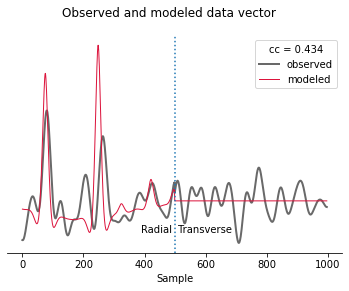

In [11]:
    predicted = predictRF(model, geometry, rc, freqs, rfarray, ist, rf=True)
    plot(observed, predicted)

The first half of the data vector is the radial, the second half the transverse component of the receiver function. In this example, without dip or anisotropy, energy only gets converted to the radial, not the transverse component. The first positive wiggle is *PS*, the second one *PpS*. Note the slight mis-alignment between observation (gray) and prediction (red). The smaller wiggles that arrive later result from the deconvolution of *PpP*.

## Inverse Modeling with Scipy's Optimize Module
We now define the search bounds for dual annealing. This definition prescribes that the first element of the model vector is the *thickness of layer 0* and is searched in an interval of $\pm$5000 m, and its second element is the *$V_P/V_S$ ratio of layer 0*, searched in an interval of $\pm$0.1.

In [12]:
    bounds = [
        (model.thickn[0] - 5000, model.thickn[0] + 5000),
        (model.vpvs[0] - 0.1, model.vpvs[0] + 0.1),
    ]

Now we are ready to perform the inversion using `scipy`'s [dual annealing](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html) function. It seeks a minimum in the `misfit` function defined above. The call is in principle interchangeable with other [global search methods from the optimization module](https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization).

In [13]:
    result = spo.dual_annealing(
        misfit,
        bounds,
        args=(model, geometry, rc, freqs, rfarray, ist, observed),
        maxiter=20,
    )
    

h = 31347, vpvs = 1.759, cc = 0.646
h = 30862, vpvs = 1.874, cc = 0.673
h = 26054, vpvs = 1.714, cc =-0.045
h = 32179, vpvs = 1.714, cc = 0.645
h = 32179, vpvs = 1.873, cc = 0.430
h = 30862, vpvs = 1.874, cc = 0.673
h = 30862, vpvs = 1.874, cc = 0.673
h = 30862, vpvs = 1.874, cc = 0.673
h = 32286, vpvs = 1.830, cc = 0.582
h = 26214, vpvs = 1.776, cc =-0.204
h = 25657, vpvs = 1.776, cc =-0.166
h = 25657, vpvs = 1.705, cc = 0.000
h = 27425, vpvs = 1.706, cc =-0.086
h = 32412, vpvs = 1.843, cc = 0.488
h = 34128, vpvs = 1.843, cc = 0.148
h = 34128, vpvs = 1.788, cc = 0.358
h = 34705, vpvs = 1.750, cc = 0.367
h = 26393, vpvs = 1.684, cc = 0.011
h = 29421, vpvs = 1.684, cc =-0.026
h = 29421, vpvs = 1.839, cc = 0.487
h = 27247, vpvs = 1.693, cc =-0.050
h = 32231, vpvs = 1.814, cc = 0.644
h = 32329, vpvs = 1.814, cc = 0.628
h = 32329, vpvs = 1.861, cc = 0.450
h = 34088, vpvs = 1.691, cc = 0.607
h = 27632, vpvs = 1.874, cc =-0.609
h = 30257, vpvs = 1.874, cc = 0.664
h = 30257, vpvs = 1.797, cc 

## Results
Let's have a look at the result

In [14]:
    print(result)

     fun: 0.2828251607896928
 message: ['Maximum number of iteration reached']
    nfev: 93
    nhev: 0
     nit: 20
    njev: 4
  status: 0
 success: True
       x: array([3.15152393e+04, 1.79459723e+00])


And assign it to the model

In [15]:
    model.thickn[0] = result.x[0]
    model.vpvs[0] = result.x[1]
    model.update(change='vs')

    msg = "Result found with dual annealing"
    print(msg)
    print(model)

Result found with dual annealing
# thickn     rho      vp      vs  flag aniso   trend plunge strike   dip
 31515.0  2800.0  6400.0  3566.3    1    0.0     0.0    0.0    0.0   0.0
     0.0  3600.0  8100.0  4600.0    1    0.0     0.0    0.0    0.0   0.0



The optimal crustal thickness is closer to 32 km, as suggested by Saul et al. (2000), and the $V_P/V_S$ ratio closer to 1.8. Note, however, that we only looked at one receiver function from one direction. We also did not make any attempt to estimate uncertainties on the solution.

Finally, we can look at how well the optimized model predicts the data.

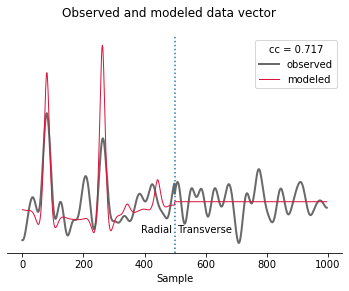

In [16]:
    predicted = predictRF(model, geometry, rc, freqs, rfarray, ist)
    plot(observed, predicted)

## Conclusion
In this example we looked into some basic functions that can be helpful when using *PyRaysum* in parameter esimtation problems. We defined a function `predictRF` to predict a receiver function from a given input model, as well as a `misfit` function whose scalar ouput should be minimized through inverse modeling. We then plugged these functions into *SciPy*'s `optimize` toolbox to estimate the thickness and *S*-wave velocity of the cratonic crust in Hyderabad, India.

## References

* Saul, J., Kumar, M. R., & Sarkar, D. (2000). Lithospheric and upper mantle structure of the Indian Shield, from teleseismic receiver functions. Geophysical Research Letters, 27(16), 2357-2360. https://doi.org/10.1029/1999GL011128